In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from fancyimpute import IterativeImputer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
data = pd.read_csv('payment-practices.csv')

In [3]:
# Drop columns that are not useful for the model
columns_to_drop = ['Report Id','Start date', 'End date', 'Filing date', 'Company', 'Company number','URL']
data = data.drop(columns=columns_to_drop)

In [4]:
# assigning types of features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object','bool']).columns
missing_data_cols = [i for i in categorical_features if data[i].isnull().sum() > 0]
non_missing_cat = [i for i in categorical_features if i not in missing_data_cols]

In [5]:
# Missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,14673,18.888789
Average time to pay,6859,8.829701
% Invoices paid within 30 days,6859,8.829701
% Invoices paid between 31 and 60 days,6859,8.829701
% Invoices paid later than 60 days,6859,8.829701
% Invoices not paid within agreed terms,6708,8.635316
Shortest (or only) standard payment period,6708,8.635316
Longest standard payment period,30562,39.342954
Maximum contractual payment period,6708,8.635316
Payment terms have changed,6708,8.635316


Handling missing data

In [6]:
data = data.dropna(subset=['Average time to pay'])

In [7]:
data['Payments made in the reporting period'].fillna(0, inplace=True)
data['Suppliers notified of changes'].fillna(1, inplace=True)

In [8]:
for col in numerical_features:
    data[col] = data[col].fillna(data[col].mean())

In [9]:
data = data.astype('int')

In [10]:
#missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,0,0.0
Average time to pay,0,0.0
% Invoices paid within 30 days,0,0.0
% Invoices paid between 31 and 60 days,0,0.0
% Invoices paid later than 60 days,0,0.0
% Invoices not paid within agreed terms,0,0.0
Shortest (or only) standard payment period,0,0.0
Longest standard payment period,0,0.0
Maximum contractual payment period,0,0.0
Payment terms have changed,0,0.0


In [11]:
n = 5

In [12]:
percentile = []
for per in range(n):
    percentile.append(np.percentile(data['% Invoices not paid within agreed terms'].dropna(), 90-(per*10)))
percentile

[64.0, 47.0, 36.0, 28.0, 22.0]

In [13]:
flags = []
for i in range(n):
    flag = []
    for j in data['% Invoices not paid within agreed terms']:
        if j > percentile[i]: flag.append(1)
        else: flag.append(0)
    flags.append(flag)
data.drop('% Invoices not paid within agreed terms',axis=1,inplace=True)

In [14]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler()
X = []
y = []
for i in range(n):
    X_over, y_over = oversampler.fit_resample(data, flags[i])
    X.append(X_over)
    y.append(y_over)

In [15]:
X_train = []
y_train = []
X_test = []
y_test = []
for i in range(n):
    a,b,c,d = train_test_split(X[i], y[i], test_size=1/3, random_state=42)
    X_train.append(a)
    X_test.append(b)
    y_train.append(c)
    y_test.append(d)


In [16]:
# from imblearn.over_sampling import RandomOverSampler
# oversampler = RandomOverSampler()
# for i in range(n):
#     X_train[i], y_train[i] = oversampler.fit_resample(X_train[i], y_train[i])

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
# XGBoost Model
params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 1,
    'subsample': 0.85,
    'n_estimators': 900,
} 

In [18]:
y_pred = []
y_pred_proba = []
model = []
for i in range(n):
    xgb_clf = XGBClassifier()
    xgb_clf.fit(X_train[i], y_train[i])
    model.append(xgb_clf)
    y_pred.append(xgb_clf.predict(X_test[i]))
    y_pred_proba.append(xgb_clf.predict_proba(X_test[i])[:, 1])
    

In [19]:
f_score = []
auc_list = []
accuracy = []
fpr = []
tpr = []
thresholds = []
for i in range(n):
    accuracy.append(accuracy_score(y_test[i], y_pred[i]))
    f_score.append(f1_score(y_test[i], y_pred[i]))
    fpr_, tpr_, thresholds_ = roc_curve(y_test[i], y_pred_proba[i])
    fpr.append(fpr_)
    tpr.append(tpr_)
    thresholds.append(thresholds_)
    auc_list.append(auc(fpr[i], tpr[i]))

Comparing the models

In [20]:
results = {
    'Risk Proportion': [str((i+1)*10)+'%' for i in range(n)],
    'Accuracy': accuracy,
    'F1 Score': f_score,
    'AUC': auc_list
}

results_df = pd.DataFrame(results)
results_df


,Risk Proportion,Accuracy,F1 Score,AUC
0,10%,0.842452,0.848175,0.916707
1,20%,0.791840,0.797891,0.873904
2,30%,0.767340,0.774024,0.848154
3,40%,0.757473,0.762625,0.832547
4,50%,0.752303,0.757860,0.829186


Receiver Operating Characteristic (ROC) Curves

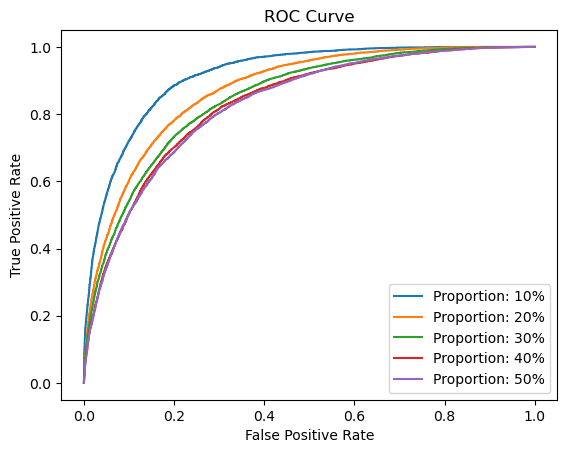

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Define the proportions
proportions = [0.1, 0.3, 0.5, 0.7, 0.9]

# Iterate over the proportions
for i in range(n):
    # Plot the ROC curve
    plt.plot(fpr[i], tpr[i], label=f'Proportion: {str((i+1)*10)}%')

# Set the labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Show the plot
plt.show()
